In [1]:
from torch_TICLNet import *
from torch_DatasetLoader import *
from pylab import *
from IPython.display import clear_output
%matplotlib inline

# 1. Training

In [2]:
# load training dataset
trainset = DatasetLoader('../data/pickle/dataset_LAYERS_train.pkl')
# initialize a model
model = TICLNet()

In [4]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# begin Training
for epoch in range(10):
    running_loss = 0.0
    for i, batch in enumerate(trainset.getBatches(batch_size=50)):
        # 1.get the inputs
        inputs = batch["feature"]
        labels = batch["label"]
        # 2.zero the parameter gradients
        optimizer.zero_grad()
        # 3.forward + backward + optimize
        outputs = model(inputs)
        loss    = F.cross_entropy( outputs, torch.tensor(labels) )
        loss.backward()
        optimizer.step()
        
        #### monitor running loss ####
        running_loss += loss.data
        if i % 10 == 9:
            print('[{:2d}, {:3d}] loss: {:5.3f}'.format(epoch+1, i+1, running_loss/10))
            clear_output(wait=True)
            running_loss = 0.0

[10, 600] loss: 0.381


In [6]:
torch.save(model.state_dict(), '../models/TICLNet.dict')

# 2. Testing

In [2]:
whichset = "test"
# load training dataset
testset = DatasetLoader('../data/pickle/dataset_LAYERS_{}.pkl'.format(whichset))
# initialize a model
model = TICLNet()
model.load_state_dict(torch.load('../models/TICLNet.dict'))
model.eval()
print('model loaded for {} dataset'.format(whichset))

model loaded for test dataset


In [3]:
# calculate softmax for testing events
softmax = []
for i in range(len(testset)):
    event = testset[i]
    X = event["feature"]
    y = F.softmax(model(X),dim=1)
    softmax.append(y.data.numpy())
softmax = np.array(softmax)  
softmax = softmax.reshape(-1,4)
predicts = np.argmax(softmax,axis=1)
labels = np.array(testset.label)

### 2.1 testing visualization

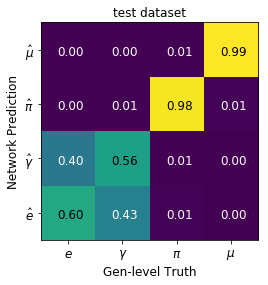

In [4]:
# a) plot confusion matrix
h = np.histogram2d(labels,predicts,bins=np.arange(5))[0]
hnorm = h.copy()
for i in range(h.shape[0]):
    hnorm[i] /= h[i].sum()
plt.figure(facecolor='w')
plt.imshow(hnorm.T,origin='lower')
plt.xlabel('Gen-level Truth',fontsize=12)
plt.ylabel('Network Prediction',fontsize=12)
plt.xticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\pi$',r'$\mu$'],fontsize=12)
plt.yticks(np.arange(4),[r'$\hat{e}$',r'$\hat{\gamma}$',r'$\hat{\pi}$',r'$\hat{\mu}$'],fontsize=12)

for i in range(4):
    for j in range(4):
        clr = 'w'
        val = hnorm[i,j]
        if val >0.5:
            clr = 'k'
        plt.text(i-0.2,j-0.1,'{:4.2f}'.format(val), color=clr,fontsize=12)
plt.title('{} dataset'.format(whichset))
plt.savefig('../plots/TICLNet/{}_confusion.png'.format(whichset),dpi=200)

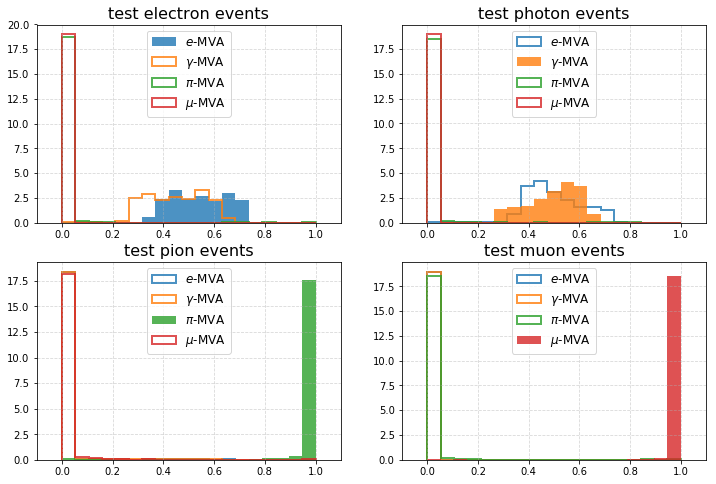

In [5]:
# b) plot MVA distribution for all labels
plt.figure(facecolor='w',figsize=(12,8))
for particle in range(4):
    temp_softmax = softmax[labels==particle]

    # prepare making plot
    mvaBins = np.linspace(0,1,20)
    mvaLabels = [r'$e$-MVA',r'$\gamma$-MVA',r'$\pi$-MVA',r'$\mu$-MVA']
    particleName = ['electron','photon','pion','muon']

    # make plot
    plt.subplot(2,2,particle+1)
    for i in range(4):
        if i == particle:
            htype = 'stepfilled'
            halpha = 0.8
        else:
            htype = 'step'
            halpha = 0.8
        plt.hist(temp_softmax[:,i], mvaBins,
                 normed=True,alpha = halpha,
                 lw=2, histtype=htype,label=mvaLabels[i])

    plt.legend(loc='upper center',fontsize=12)
    plt.grid(linestyle='--',alpha=0.5)
    plt.xlim(-0.1,1.1)
    #plt.xlabel('TICLNet Score',fontsize=14)
    plt.title('{} {} events'.format(whichset, particleName[particle]),fontsize=16)
plt.savefig('../plots/TICLNet/{}_mva.png'.format(whichset),dpi=200)

In [6]:
# c) plot event summary
for i in range(100):
    plt.figure(figsize=(5,2))
    eventSummary = model.summarizeBatchEvents( testset[i]["feature"]).data.numpy()
    plt.imshow(eventSummary,vmax=1,vmin=0)
    #plt.colorbar(shrink=0.65)
    plt.xlabel("layer")
    plt.ylabel("summary channel")
    plt.savefig("../plots/TICLNet/summary/{}_event_{}.png".format(whichset,i),dpi=200)
    plt.close()